# Baseline CNN

A deep CNN with 6 conv layers to classify (280, 32, 32) stft images derived from eeg signals.

In [118]:
import torch
from torch import nn
from torch.utils.data import Subset, DataLoader
from torchvision import transforms, datasets
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

# Load Data

In [2]:
def load_data(root):
    transform =  transforms.Compose(
        [
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(0, 1, inplace=False)
        ]
    )
    return datasets.ImageFolder(root=root, transform=transform)

In [3]:
def split_data(dataset, train_ids, test_ids, batch_size=28):
    train_subset = Subset(dataset, train_ids)
    test_subset = Subset(dataset, test_ids)
    train_dataloader = DataLoader(train_subset, batch_size=batch_size)
    test_dataloader = DataLoader(test_subset, batch_size=1)
    return train_dataloader, test_dataloader

# Classifier

In [48]:
class Classifier(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Classifier, self).__init__()

        self.classifier = nn.Sequential(
            self.make_c_block(im_chan, hidden_dim, stride=1),
            self.make_c_block(hidden_dim, hidden_dim),
            self.make_c_block(hidden_dim, hidden_dim),
            self.make_c_block(hidden_dim, hidden_dim),
            self.make_c_block(hidden_dim, hidden_dim, kernel_size=2),
            self.make_c_block(hidden_dim, 1, kernel_size=2, padding=0, final_layer=True)
        )

    def make_c_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
            if not final_layer:
                return nn.Sequential(
                    nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding=padding),
                    nn.BatchNorm2d(output_channels, momentum=0.1),
                    nn.LeakyReLU(0.2),
                    )
            else:
                    return nn.Sequential(
                    nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding=padding),
                    nn.Sigmoid(),
                    )
    def forward(self, img):
        pred_class = self.classifier(img)
        return pred_class.view(-1)

In [95]:
classifier = Classifier(hidden_dim=32)
print(f'classifier parameters: {sum(p.numel() for p in classifier.parameters())}')

classifier parameters: 54369


# Init

In [96]:
def weights_init(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight)

    if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1.0)
        nn.init.constant_(m.bias, 0.0)

# Training

In [108]:
def train(classifier, train_dataloader):

    ## Training loop
    epochs = 40
    device = 'cpu'
    display_step = 60

    cur_step = 0
    classifier_mean_error = 0
    
    print('Training Starts...\n')
    classifier.training = True

    for epoch in range(epochs):
        for real, labels in train_dataloader:
            cur_batch_size = len(real)
            real = real.to(device=device)

            #-----------
            ## Classifier
            #-----------
            classifier.zero_grad()

            real_pred_class = classifier(real)
            classifier_loss = criterion(real_pred_class, labels.float()) 

            classifier_loss.backward(retain_graph=False)
            classifier_opt.step()
            #-------------

            with torch.no_grad():
                # batch accuracy
                classifier_mean_error += (abs(real_pred_class - labels).sum() / cur_batch_size) * 100

                cur_step += 1
                if cur_step % display_step == 0:
                    print(
                        f'Epoch: {epoch} / {epochs}, Step: {cur_step} \n' +
                        f'Batch Mean error: {classifier_mean_error / display_step:.2f}% \n'
                    )

                    classifier_mean_error = 0
    return classifier

# Test

In [109]:
def test(classifier, test_dataloader):
    err = []
    with torch.no_grad():
        classifier.training = False

        for real, labels in test_dataloader:
            pred_class = classifier(real)
            err.append(abs(labels - pred_class.round()).item())

        test_error = (sum(err)/len(err)) * 100
        print(f'Test Error: {test_error:.2f}%')
        print(30 * '-')

        return test_error

# Main

In [110]:
# params
batch_size = 28

In [111]:
# Optimizer
lr_classifier = 0.001
beta_1, beta_2 = 0.5, 0.999

classifier_opt = torch.optim.Adam(params=classifier.parameters(), lr=lr_classifier, betas=(beta_1, beta_2))

In [112]:
criterion = nn.BCEWithLogitsLoss()

In [115]:
torch.manual_seed(42);

root = '~/PERSONAL_DIR/github/bci-research/src/data/graz/stft_image_data'
dataset = load_data(root)

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
test_error = []
# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    print(f'|Fold: {fold}|')
    tr_loader, test_loader = split_data(dataset, train_ids, test_ids, batch_size=28)
    classifier = classifier.apply(weights_init)
    classifier = train(classifier, tr_loader)
    test_error.append(test(classifier, test_loader))

print(f'Mean Test Error: {torch.tensor(test_error).mean().item():.2f}%')
print(30 * '-')

|Fold: 0|
Training Starts...

Epoch: 7 / 40, Step: 60 
Batch Mean error: 33.15% 

Epoch: 14 / 40, Step: 120 
Batch Mean error: 1.58% 

Epoch: 22 / 40, Step: 180 
Batch Mean error: 0.39% 

Epoch: 29 / 40, Step: 240 
Batch Mean error: 0.24% 

Epoch: 37 / 40, Step: 300 
Batch Mean error: 0.16% 

Test Error: 16.07%
------------------------------
|Fold: 1|
Training Starts...

Epoch: 7 / 40, Step: 60 
Batch Mean error: 33.78% 

Epoch: 14 / 40, Step: 120 
Batch Mean error: 1.77% 

Epoch: 22 / 40, Step: 180 
Batch Mean error: 0.50% 

Epoch: 29 / 40, Step: 240 
Batch Mean error: 0.29% 

Epoch: 37 / 40, Step: 300 
Batch Mean error: 0.20% 

Test Error: 14.29%
------------------------------
|Fold: 2|
Training Starts...

Epoch: 7 / 40, Step: 60 
Batch Mean error: 31.17% 

Epoch: 14 / 40, Step: 120 
Batch Mean error: 2.07% 

Epoch: 22 / 40, Step: 180 
Batch Mean error: 0.44% 

Epoch: 29 / 40, Step: 240 
Batch Mean error: 0.27% 

Epoch: 37 / 40, Step: 300 
Batch Mean error: 0.17% 

Test Error: 19.64%

# Analyse

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline

classifier.0.0.weight (32, 1, 4, 4) | mean: 0.033 | std: 0.355
classifier.1.0.weight (32, 32, 4, 4) | mean: -0.001 | std: 0.064
classifier.2.0.weight (32, 32, 4, 4) | mean: 0.001 | std: 0.064
classifier.3.0.weight (32, 32, 4, 4) | mean: 0.000 | std: 0.065
classifier.4.0.weight (32, 32, 2, 2) | mean: -0.002 | std: 0.126
classifier.5.0.weight (1, 32, 2, 2) | mean: 0.017 | std: 0.152


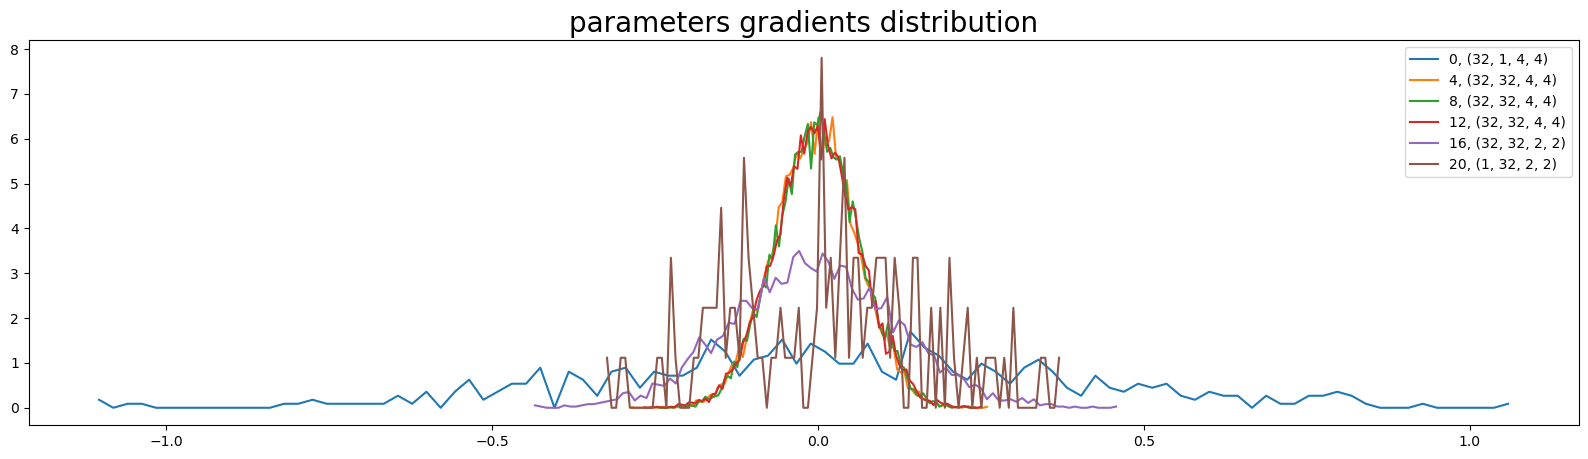

In [116]:
fig, ax = plt.subplots(figsize=(20, 5))
legends = []
for i, (name, p) in enumerate(classifier.named_parameters()):
    if p.ndim == 4:
        t = p
        print(f'{name} {tuple(p.shape)} | mean: {p.mean().item():.3f} | std: {p.std().item():.3f}')
        hy, hx = torch.histogram(t, density=True)
        ax.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i}, {tuple(p.shape)}')

ax.legend(legends)
ax.set_title('parameters gradients distribution', fontsize=20);